In [1]:
%matplotlib inline

In [2]:
from IPython.display import Image
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
import random
import patsy
import pandas as pd
import models
from collections import defaultdict

sns.set(style="whitegrid")

# Brandon Morrow

We will apply Linear Regression and Model Evaluation

## 1.1 - ETL

Lets start out by analyzing the names location and pulling the names of the features. We find from their rollup:

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

Missing Attribute Values:  horsepower has 6 missing values

Now we can go ahead and load the dataframe, and then we will add the headers above to this dataframe. We also need to handle the missing values, which on a quick glance at the datafile we see that they are annotated with '?'. I think the best way after research to read this file in will be using pandas read fwf function.

In [3]:
headers = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
auto_df = pd.read_fwf('https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt', header=None, na_values='?')
auto_df.columns = headers

Now that we have loaded our dataframe lets check the head of the dataframe to make sure that it loaded properly, and that all of the headers are reflecting.

In [4]:
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


Now we need to check to make sure that the null values were read into the dataframe correctly. There should be 6 null values in the horsepower feature, and no null values in any of the other features. Lets check with pandas info function.

In [5]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


We see that the nulls were correctly handled when reading in the file, and that all features except for car name are int or float64 and not object. This looks like a good read in. Since we will get issues having null values in the horsepower column lets handle these. We will replace all null values with the mean of the horsepower.

In [6]:
auto_df['horsepower'] = auto_df['horsepower'].fillna(auto_df['horsepower'].mean())
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


## 1.2 - EDA

* Summarize key findings from Part 1
* Present your Null Model from Part 1

Lets look at our CLD from our previous EDA displaying the relationship between each feature and MPG.

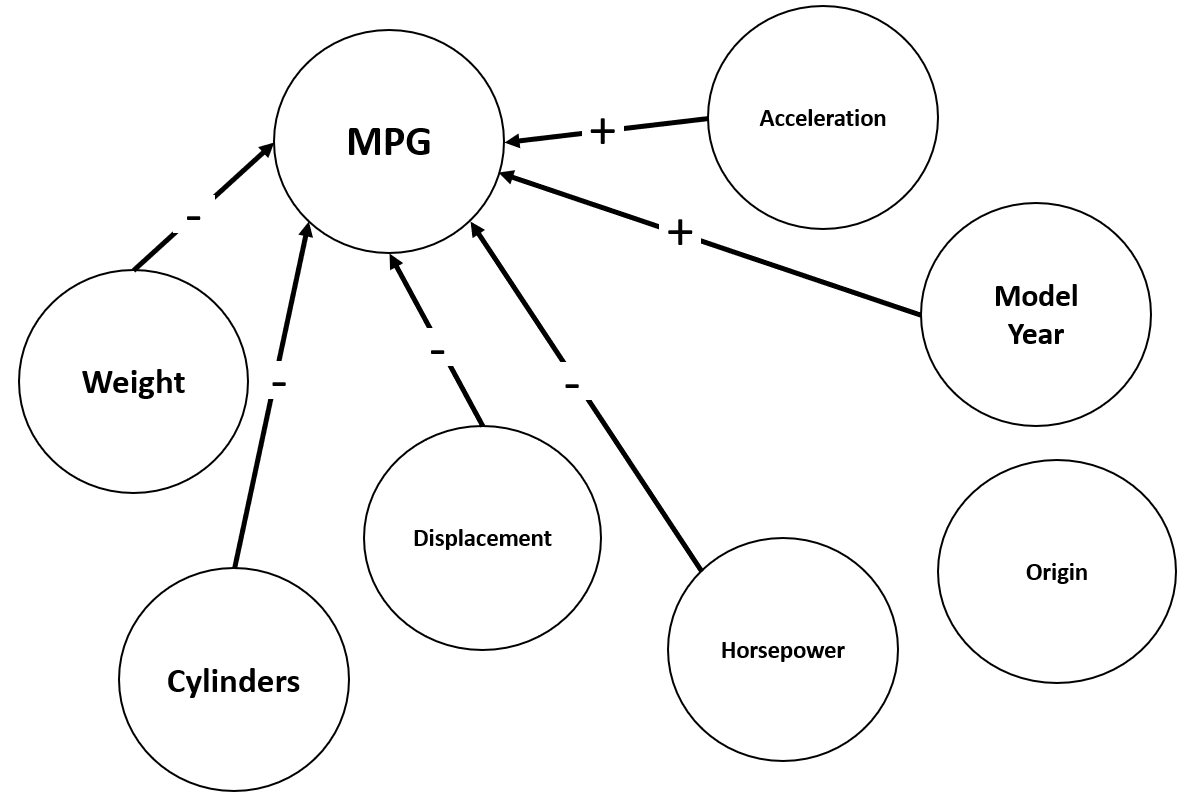

In [7]:
Image("mpg_cld.png", width=600, height=600)

### MPG Single Variable Summary

Miles per gallon is a numeric variable. Just based off of domain knowledge I expect that this data may be normally distributed with most vehicles being around the 30mpg mark. Lets first look at the summary statistics for MPG to get a better sense for the range covered.

In [8]:
auto_df["mpg"].describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The minimum MPG is actually 9 MPG with a maximum of 46.6. The mean is actually located at 23.5 which is lower than we expected. The median is at 23 which is close to the mean value, but the data appears to be somewhat skewed to the right.. Since this is numerical we can look at the histogram to get a visual. Lets define the Freeman Diaconis bin function as well which we will use here and later in our EDA.

In [9]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

Freeman Diaconis:  3


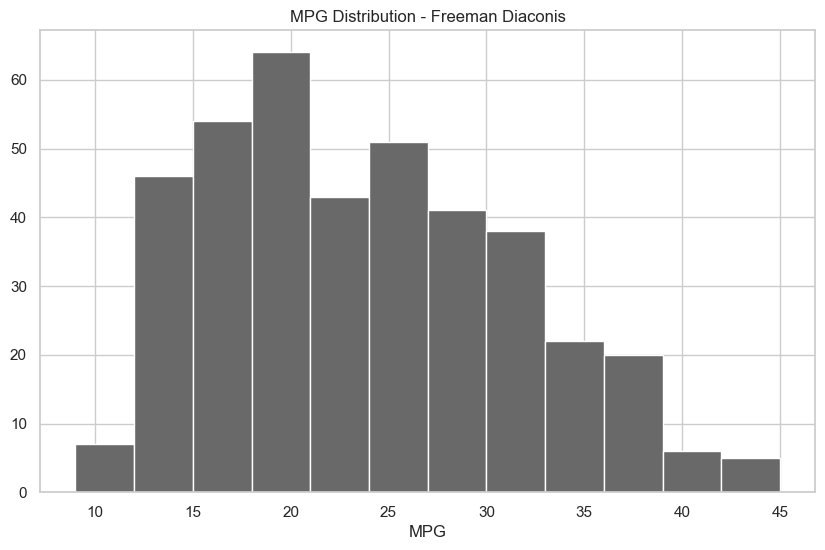

In [10]:
h = freeman_diaconis(auto_df.mpg)
print("Freeman Diaconis: ", h)
mn = int(auto_df.mpg.min())
mx = int(auto_df.mpg.max())
bins = [i for i in range( mn, mx, h)]

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(auto_df.mpg,bins=bins, color="dimgray")
axes.set_title("MPG Distribution - Freeman Diaconis")
axes.set_xlabel("MPG")

plt.show()
plt.close()

Most vehicles appear around the 15-25 MPG range, and we do see a slight skew to the right here. This mpg data makes sense after looking back for more domain knowledge and at the dataset we see that these vehicles are from the 1970s. So this explains why the mean miles per gallon are lower than we initially anticipate for modern vehicles.

### MPG v. ? Pairwise Summary

Typically we go one variable at a time, but we can refer back to our 5.1 notebook for that. In this summary I will summarize what we found. 

We found that there was a negative relationship between mpg and: cylinders, displacement, horsepower, and weight. There is a positive relationship between MPG vs Acceleration, and MPG vs Model Year. Lets go ahead and look at the Pearson's R and Spearman's $\rho$ for these as a reminder.

In [11]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

In [12]:
correlations(auto_df, "mpg", ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"])

,feature,r,rho
0,cylinders,-0.775396,-0.821864
1,displacement,-0.804203,-0.855692
2,horsepower,-0.771437,-0.843180
3,weight,-0.831741,-0.874947
4,acceleration,0.420289,0.438677
5,model_year,0.579267,0.573469


As we just discussed we see strong negative monotonic relationships between MPG and cylinders, displacement, horsepower, and weight. We see a low positive relationship between mpg and Acceleration and a moderate positive relationship between MPG and Model Year. Now lets visualize. 

In [13]:
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [14]:
def pairwise_scatterplots(data, variable1, variable2, lowess=True, flip=False):
    num_plots = len(variable2)
    plots_per_row = 3
    num_rows = num_plots // plots_per_row + (num_plots % plots_per_row > 0)
    
    fig, ax_array = plt.subplots(num_rows, plots_per_row, figsize=(15, 6*num_rows))
    
    for i in range(num_plots):
        row_idx = i // plots_per_row
        col_idx = i % plots_per_row
        ax = ax_array[row_idx, col_idx] if num_rows > 1 else ax_array[i]
        if flip:
            x_var, y_var = variable1, variable2[i]
        else:
            x_var, y_var = variable2[i], variable1
        if lowess:
            low = sm.nonparametric.lowess(data[y_var], data[x_var])
            lowess_x, lowess_y = zip(*low)
            ax.scatter(data[x_var], data[y_var], marker="o", color="dimgray")
            ax.plot(lowess_x, lowess_y, color="DarkRed")
            ax.set_title(f"{y_var.capitalize()} vs. {x_var.capitalize()} with Lowess")
        else:
            ax.scatter(data[x_var], data[y_var], marker="o", color="dimgray")
            ax.set_title(f"{y_var.capitalize()} vs. {x_var.capitalize()}")
        ax.set_xlabel(x_var.capitalize())
        ax.set_ylabel(y_var.capitalize())
    
    plt.show()
    plt.close()


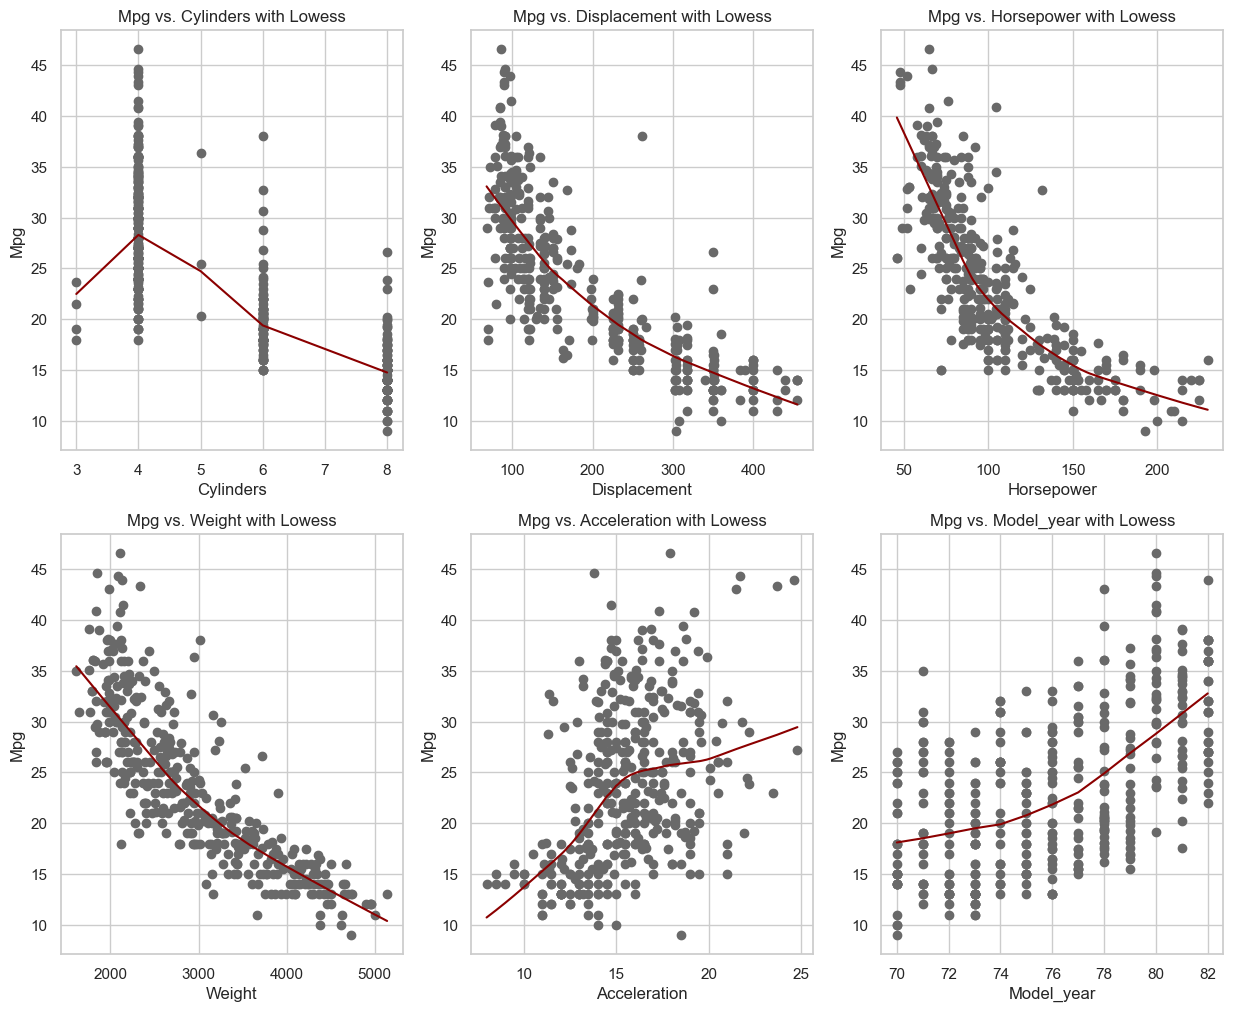

In [15]:
pairwise_scatterplots(auto_df, "mpg", ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"])

We can now visually see the relationships that we talked about. Lets now move on to our baseline/null model.

## Baseline or Null Model

We would like to predict vehicle miles per gallon. We want to penalize over estimates and under estimates the same. We want to penalize large errors more than small errors. Therefore we can use the (R)MSE as our loss function and our baseline/null model will therefore be the mean

In [16]:
mpg_predict = auto_df.mpg.mean()
mpg_predict

23.514572864321607

In [17]:
mpg_std = auto_df.mpg.std()
mpg_std

7.815984312565782

We predict an MPG of 23.515 with standard deviation of 7.816 MPG. Lets find our error bounds. This data is skewed so we are best off using the 2.5% and 97.5% percentiles. 

In [18]:
np.percentile(auto_df.mpg, [2.5, 97.5])

array([12.    , 39.1225])

We have a predicted value of 23.51 MPG with error bounds at 12 and 39.12 MPG. 

## 1.3 - Build the linear model

* this is going to be the bulk of the code and discussion
* we are more interested in *process* than a particular RMSE, ie, are you doing the right things?

To build our linear model we first need to look at the data to make sure it is in proper format and encode any categorical variables that need to be encoded. Lets work through any required transformations. 

## Transformations

Lets again see what we are working with and the variables in the data. We need to determine if there are any transformations needed.

In [19]:
auto_df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name'],
      dtype='object')

In [20]:
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


Since cylinders and model year are numeric categoricals and are in the correct order so we do not need to conduct any transformations on our dataframe. 

In [21]:
features = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin"]

## Correlations

Now that we have our features lets move to analyze our correlations. Lets first look at Pearson's r correlation coefficients and the linear relationship of our features.

In [22]:
auto_df[features].corr()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
cylinders,1.000000,0.950721,0.838939,0.896017,-0.505419,-0.348746,-0.562543
displacement,0.950721,1.000000,0.893646,0.932824,-0.543684,-0.370164,-0.609409
horsepower,0.838939,0.893646,1.000000,0.860574,-0.684259,-0.411651,-0.453669
weight,0.896017,0.932824,0.860574,1.000000,-0.417457,-0.306564,-0.581024
acceleration,-0.505419,-0.543684,-0.684259,-0.417457,1.000000,0.288137,0.205873
model_year,-0.348746,-0.370164,-0.411651,-0.306564,0.288137,1.000000,0.180662
origin,-0.562543,-0.609409,-0.453669,-0.581024,0.205873,0.180662,1.000000


We see that there is a strong correlation between the weight and displacement, and between displacement and cylinders. Due to this we should remove the displacement feature in our model for easier interpretation. Now lets redifine our features parameter

In [23]:
features = ["cylinders", "horsepower", "weight", "acceleration", "model_year", "origin"]

In [24]:
correlations(auto_df, "mpg", features)

,feature,r,rho
0,cylinders,-0.775396,-0.821864
1,horsepower,-0.771437,-0.843180
2,weight,-0.831741,-0.874947
3,acceleration,0.420289,0.438677
4,model_year,0.579267,0.573469
5,origin,0.563450,0.580694


We see moderately strong negative linear and monotonic relationships between MPG and cylinders, horsepower, and weight. We see moderate postive relationships between MPG and acceleration and model year.

## All-In Initial Method:

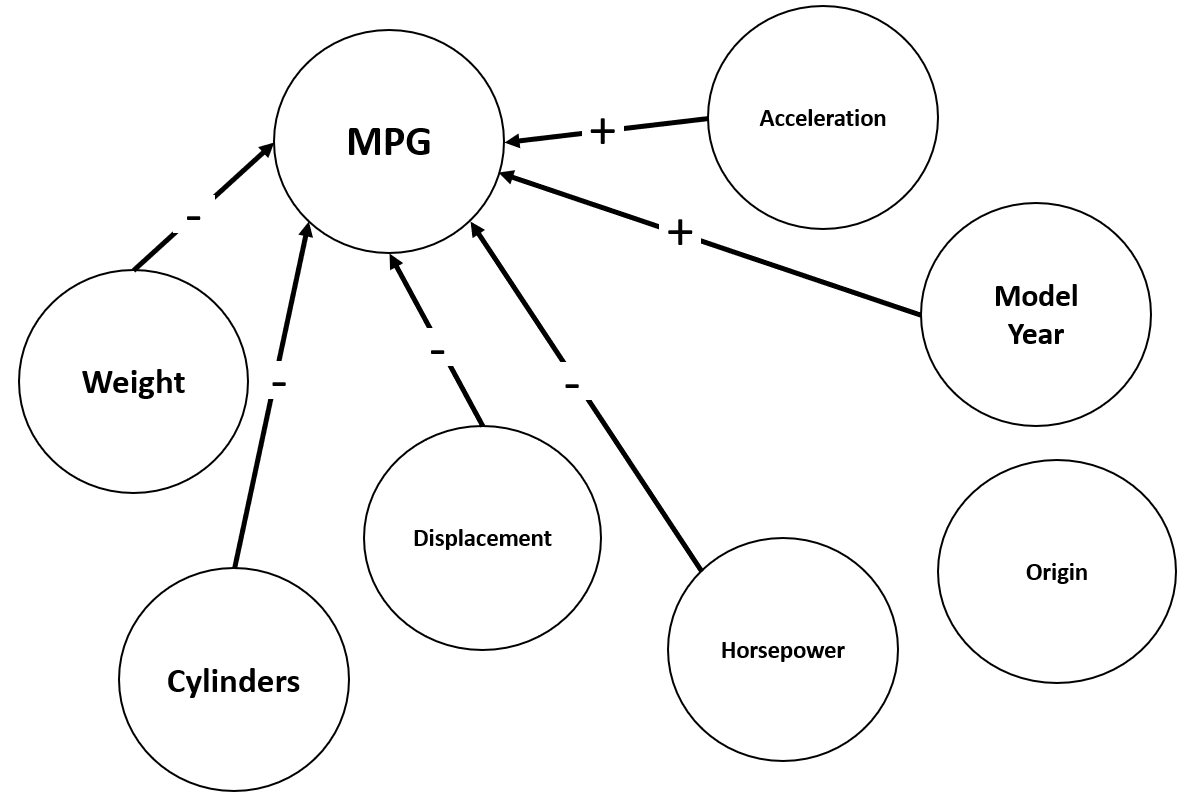

In [25]:
Image("mpg_cld.png", width=400, height=400)

As we always do lets start with the all in model for our linear regression:

In [26]:
all_in_model = "mpg ~ cylinders + horsepower + weight + acceleration + model_year + origin"

In [27]:
result = models.bootstrap_linear_regression(all_in_model, data=auto_df)
models.describe_bootstrap_lr(result)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-18.80,-26.51,-9.06
cylinders,$\beta_{1}$,0.12,-0.40,0.67
horsepower,$\beta_{2}$,-0.00,-0.02,0.03
weight,$\beta_{3}$,-0.01,-0.01,-0.00
acceleration,$\beta_{4}$,0.07,-0.12,0.36
model_year,$\beta_{5}$,0.75,0.65,0.84
origin,$\beta_{6}$,1.20,0.77,1.66
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


We see a decent $R^2$ value of 0.82 with the credible interval left bound of 0.80, and right bound of 0.85. We see that the error ($\sigma$) is 3.36 MPG with left bound 3.01 and right bound 3.63 MPG. Lets look at the variables. 

| coefficient |     value | expected | credible | decision |
|-------------|----------:|----------|----------|----------|
| cylinders   |    0.12   | no       | no       | remove   |
| horsepower  |     -0.00 | yes      | no       | keep  |
| weight      |    -0.01  | yes      | yes      | keep    |
| acceleration|     0.07  | yes      | no       | keep    |
| model_year  |    0.75   | yes      | yes      | keep    |
| origin      |    1.20   | yes      | yes      | keep    |

We see that cylinders is not credible since its credible interval contains zero and the beta value is opposite sign from what we expected to see. The other features are the sign that we expected to see so we will keep those for now. Lets move to our next model to see how we perform removing horsepower.

In [28]:
model2 = "mpg ~ horsepower + weight + acceleration + model_year + origin"

In [29]:
result2 = models.bootstrap_linear_regression(model2, data=auto_df)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-18.35,-27.53,-11.69
horsepower,$\beta_{1}$,-0.00,-0.02,0.03
weight,$\beta_{2}$,-0.01,-0.01,-0.00
acceleration,$\beta_{3}$,0.06,-0.12,0.32
model_year,$\beta_{4}$,0.74,0.67,0.84
origin,$\beta_{5}$,1.18,0.73,1.75
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.36,3.03,3.60,


We see no change in our $R^2$ value, which remains at 0.82. We see that there is no change to the credible interval with the left bound at 0.80 and right bound at 0.84. We see that the error ($\sigma$) has remained the same at 3.36, but the credible interval has slightly shifted with left bound shifting from 3.01 to 3.03, and right bound from 3.63 to 3.60. Lets now examine these coefficients: 

| coefficient |     value | expected | credible | decision |
|-------------|----------:|----------|----------|----------|
| horsepower  |    -0.00  | yes      | no       | keep     |
| weight      |    -0.01  | yes      | yes      | keep    |
| acceleration|     0.06  | yes      | no       | keep    |
| model_year  |     0.74  | yes      | yes      | keep    |
| origin      |     1.18  | yes      | yes      | keep    |

We see what we would expect to see. Horsepower seems right on the edge of removal, but lets keep it since it is in line with what we expect to see from it. Now lets move to analyzing the residuals.

## Residuals

In [30]:
def plot_residuals(data, result, variables):
    figure = plt.figure(figsize=(20,12))

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    

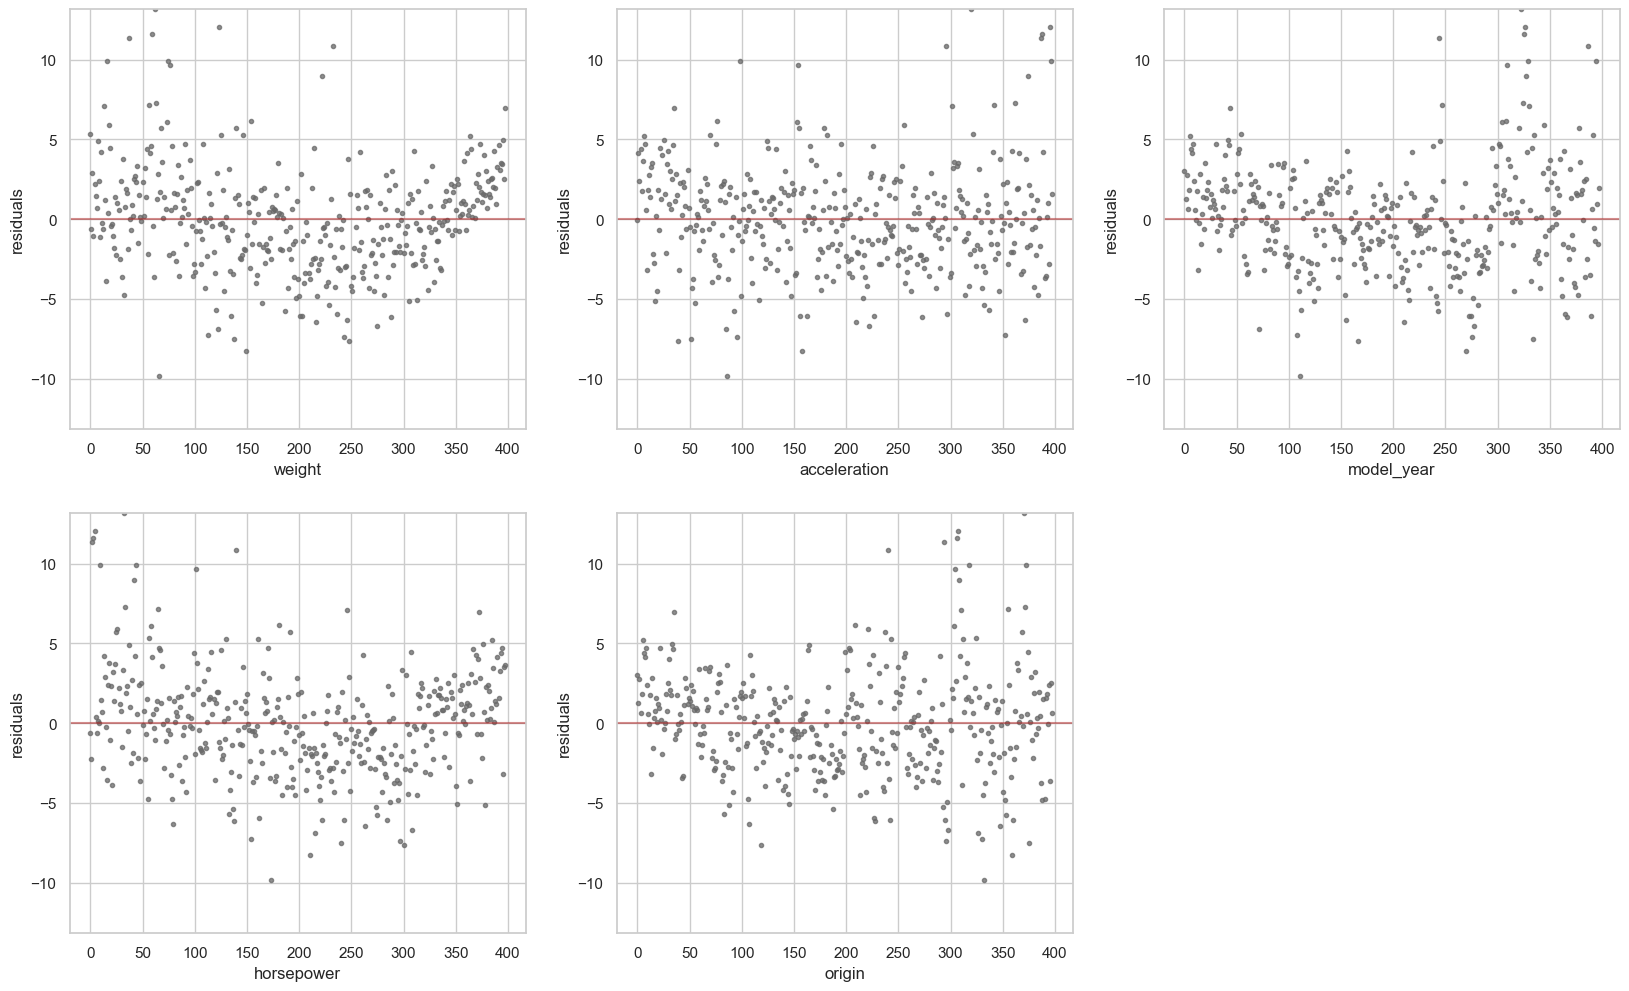

In [31]:
features = ["weight", "acceleration", "model_year", "horsepower", "origin"]
residuals = plot_residuals(auto_df, result2, features)

It almost looks like there is a U shape curve in weight, model year, and horsepower.This is most likely due to their stronger monotonic relationship with MPG than a linear relationship. Lets square those to see if we can get any increase in our $R^2$. 

## Add weight_squared

In [32]:
auto_df["weight_squared"] = auto_df.weight.apply(lambda x: x**2)

In [33]:
model3 = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared"

In [34]:
result3 = models.bootstrap_linear_regression(model3, data=auto_df)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1.48,-6.54,11.66
horsepower,$\beta_{1}$,-0.01,-0.03,0.01
weight,$\beta_{2}$,-0.02,-0.02,-0.02
acceleration,$\beta_{3}$,0.05,-0.19,0.26
model_year,$\beta_{4}$,0.80,0.71,0.88
origin,$\beta_{5}$,0.55,0.07,1.03
weight_squared,$\beta_{6}$,0.00,0.00,0.00
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


We do see an increase in our $R^2$ with it moving from 0.82 to 0.85. We also see our mean error ($\sigma$) dropped from 3.35 on our last model to 3.0. Lets see if we get any increase adding model year squared. Oddly it has a zero coefficient, but is improving our performance. 

## Add model_year_squared

In [35]:
auto_df["model_year_squared"] = auto_df.model_year.apply(lambda x: x**2)

In [36]:
model4 = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared"

In [37]:
result4 = models.bootstrap_linear_regression(model4, data=auto_df)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,423.35,291.00,541.64
horsepower,$\beta_{1}$,-0.03,-0.05,-0.01
weight,$\beta_{2}$,-0.02,-0.02,-0.02
acceleration,$\beta_{3}$,0.02,-0.18,0.20
model_year,$\beta_{4}$,-10.32,-13.42,-6.85
origin,$\beta_{5}$,0.65,0.17,1.11
weight_squared,$\beta_{6}$,0.00,0.00,0.00
model_year_squared,$\beta_{7}$,0.07,0.05,0.09
,,,,


Nice we also see an increase here with our mean $R^2$ increasing from 0.85 to 0.87. We also see another drop in mean error ($\sigma$) with it dropping from 3.0 to 2.88. We see that the model year squared coefficient has a mean value of 0.07. Interestingly we see that this makes model year negative with a credible interval. Lets now move to horsepower. 

## Add horsepower_squared

In [38]:
auto_df["horsepower_squared"] = auto_df.horsepower.apply(lambda x: x**2)

In [39]:
model5 = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + horsepower_squared"

In [40]:
result5 = models.bootstrap_linear_regression(model5, data=auto_df)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,392.75,262.06,511.22
horsepower,$\beta_{1}$,-0.16,-0.22,-0.07
weight,$\beta_{2}$,-0.02,-0.02,-0.01
acceleration,$\beta_{3}$,-0.11,-0.31,0.07
model_year,$\beta_{4}$,-9.45,-12.49,-6.08
origin,$\beta_{5}$,0.72,0.34,1.13
weight_squared,$\beta_{6}$,0.00,0.00,0.00
model_year_squared,$\beta_{7}$,0.07,0.05,0.09
horsepower_squared,$\beta_{8}$,0.00,0.00,0.00


This one brings no change to our mean $R^2$ with only a .01 shift upward in its credible interval, but there is a slight drop in our error sigma_squared. We see that horsepower squared like the weight has a coefficient of zero. Now lets again look at the residuals. 

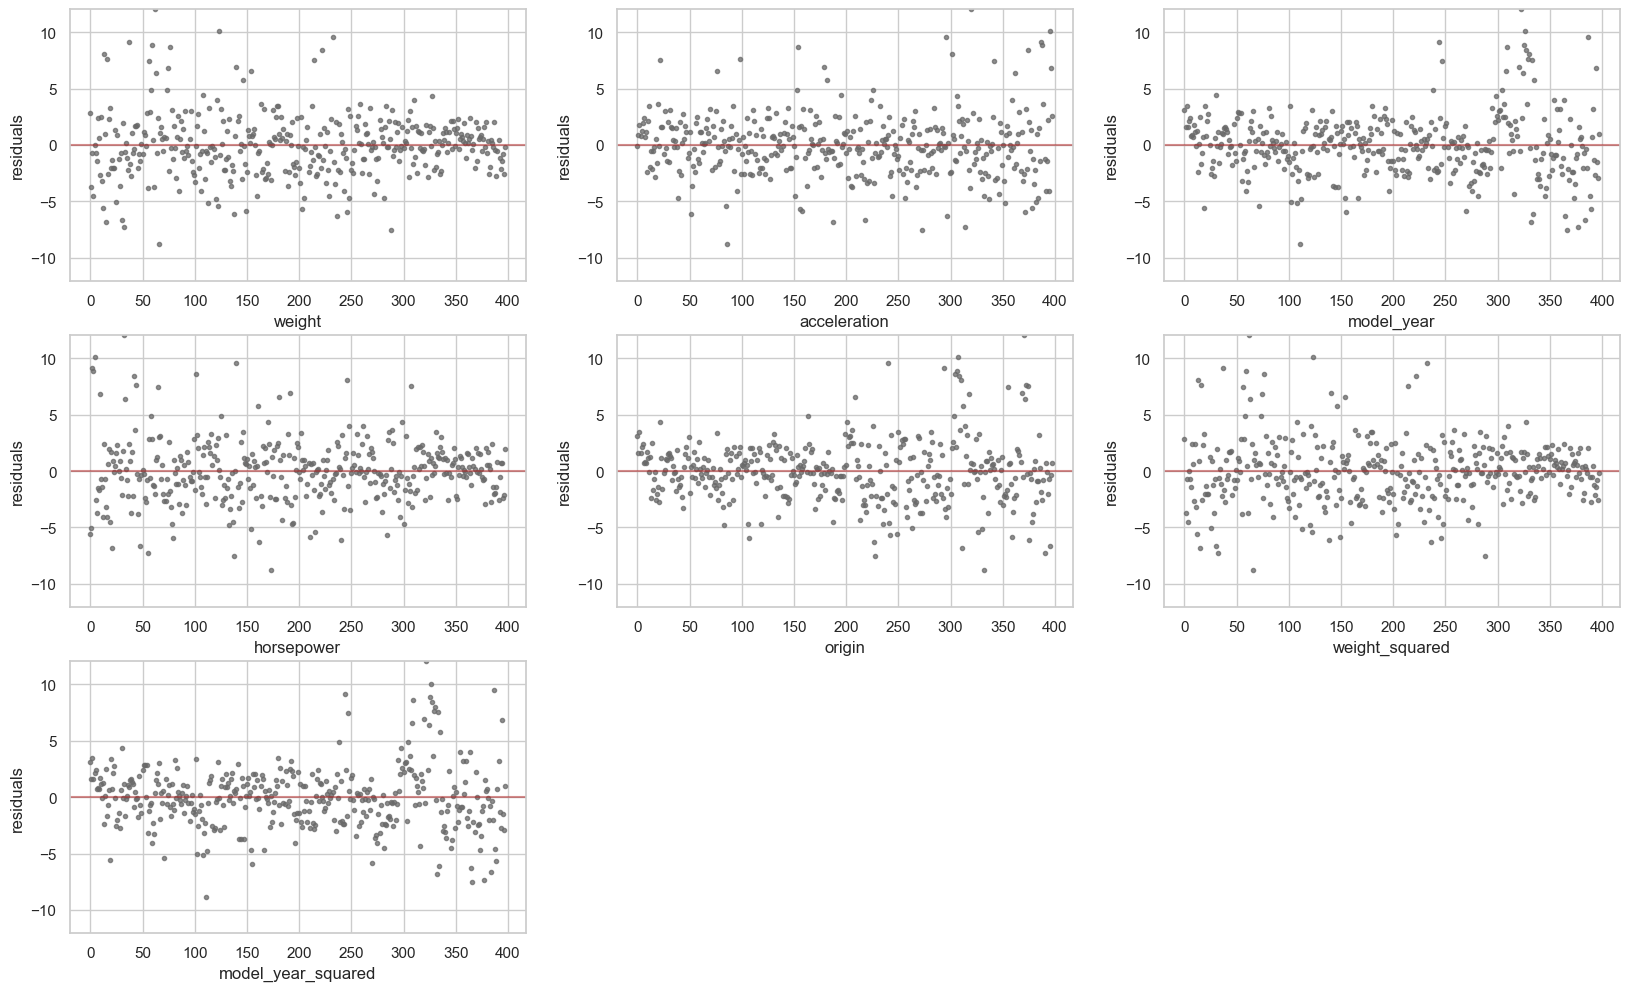

In [41]:
features = ["weight", "acceleration", "model_year", "horsepower", "origin", "weight_squared", "model_year_squared"]
residuals = plot_residuals(auto_df, result5, features)

There are no obvious patterns here so we can move forward to our interaction curves. Lets also remove the horsepower squared term since it does not really have an affect on our model, and just adds to the complexity unncecessarily, and our residual plots look good now.

In [42]:
auto_df.drop("horsepower_squared", axis=1, inplace=True)

## Interaction Terms

In [43]:
print(auto_df.columns)

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name', 'weight_squared',
       'model_year_squared'],
      dtype='object')


From our domain knowledge and EDA we saw I believe there is a strong combined interaction between acceleration and horsepower. I believe there will be a joint affect on our MPG.

In [44]:
model6 = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"
result6 = models.bootstrap_linear_regression(model6, data=auto_df)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,373.26,240.08,494.16
horsepower,$\beta_{1}$,0.05,0.01,0.10
weight,$\beta_{2}$,-0.02,-0.02,-0.01
acceleration,$\beta_{3}$,0.60,0.22,0.98
model_year,$\beta_{4}$,-9.28,-12.44,-5.72
origin,$\beta_{5}$,0.65,0.25,1.12
weight_squared,$\beta_{6}$,0.00,0.00,0.00
model_year_squared,$\beta_{7}$,0.07,0.04,0.09
acceleration:horsepower,$\beta_{8}$,-0.01,-0.01,-0.00


We do see a slight increase in our model with acceleration:horsepower increasing our mean $R^2$ to 0.88. Our mean error $\sigma$ also decreased by 0.03 to 2.79. Due to the variables weight, displacement, cylinders, and horsepower being closely related I don't think any of these interacting with acceleration will increase our explained variance $R^2$. Now lets see what the total change was in terms of our adjusted $R^2$ from our first model to now.

In [45]:
print(models.adjusted_r_squared(result))
print(models.adjusted_r_squared(result6))

0.8142466391361558
0.8722478318833334


We observed a 0.06 (6%) increase in the adjusted $R^2$ from our initial model to our final model, indicating an improvement in the model's ability to explain the variance in MPG. We will now proceed with cross-validation to further evaluate the model's performance.

## 10-Fold Cross Validation

Lets first define the functions that we will be using for cross validation. This first function divides `xs` into `n` chunks to make the folds. 

In [46]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

The next function does the cross validation:

In [47]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

Now lets run a 10 fold cross validation on our model and data:

In [48]:
formula = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"
result = cross_validation(models.linear_regression, formula, auto_df, lambda r: (r["sigma"], r["r_squared"]))

We now have 30 estimates of each metrix ($\sigma$ and $R^2$) which is sufficient to estimate credible bounds by getting the quantiles.  

In [49]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

95% CI for sigma: [1.85662195 4.21100805]


In [50]:
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result], [0.025, 0.975]))

95% CI for R^2: [0.78501993 0.94732838]


We get a relatively small sized 95% credible interval here for $\sigma$ with it ranging from 1.85 to 4.21 MPG. We see a decent size credible interval for our $R^2$ with it ranging from 0.79 to 0.95. Lets now look at the mean values:

In [51]:
sigmas = [r[0] for r in result]
r_squareds = [r[1] for r in result]

In [52]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  3.0965004928079853
mean R^2:  0.8729880541506259


We see that there is a mean error $\sigma$ of 3.09 and a mean $R^2$ of 0.87. Lets now bootstrap our results:

In [53]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [54]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [55]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))

95% CI for *mean* sigma: [2.91440865 3.31501055]


In [56]:
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* R^2: [0.85928177 0.88674418]


We now see pretty tight $\sigma$ and $R^2$ bounds with $\sigma$ ranging from 2.91 and to 3.31 and $R^2$ ranging from 0.86 to 0.89. Lets move on to our learning curves.

## Learning Curves

In [57]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [58]:
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=10):
    indices = list(range(len( data)))

    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: ## ensures 100% is al
                ## the indices are already shuffled so we only need to take ever increasin
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                ## we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                ## we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                ## we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    ## process results
    ## Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

In [59]:
formula = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"
result = learning_curves(models.linear_regression, formula, auto_df, lambda r: r["sigma"])

Now we need to define our functions to plot our learning curves:

In [60]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [61]:
def plot_learning_curves( results, metric, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()
#

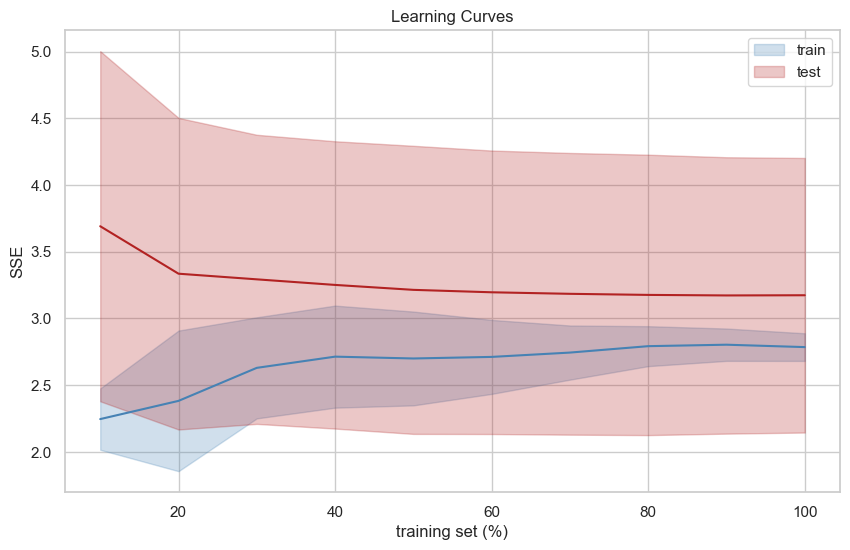

In [62]:
plot_learning_curves(result, r"SSE")

This apears to be close to converging at the end, but not fully so we may need more data. Lets get a closer look at this. 

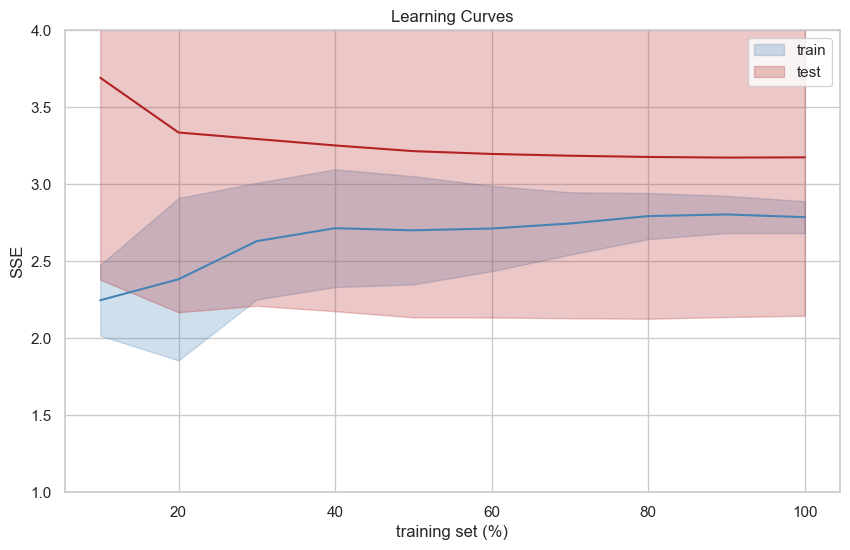

In [63]:
plot_learning_curves(result, r"SSE", zoom=True)

It looks like for the test set error the mean value is around 3.25 MPG, and for the train test error there is a mean value of 2.75 MPG. There is a .5 MPG difference so there is close to converging. We see that the 95% credible intervals for train and test are overlapping suggesting that these values actually converge, and we do not need any more data. since the mean values do not fully converge we could benefit from more data, but it will not have dramatic improvement on our model.

## Validation Curves

### Validation Curve- Weight $^n$

Since we squared some of our values lets try some validation curves to see if we would be able to adjust the squared values to a different exponential value. Lets test:

In [64]:
def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)

        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                ## it's ok to resuse the folds for each v of values
                ## we calculate the model
                result = algorithm(f, train_data, v)
                model = result["model"]
                ## we calculate the results for the training data subset
                y, X = patsy.dmatrices(f, train_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                ## we calculate the results for the test data.
                y, X = patsy.dmatrices(f, test_data, return_type="matrix")
                result = models.summarize(f, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
    ## process results
    ## Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

We want to test from 1.5 to 2.5 to see if there is a best value for our model.

In [65]:
values = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
formulas = []
formula = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"
auto_temp = auto_df.copy()

for v in values:
    auto_temp[f'weight_{str(v).replace(".", "_")}'] = auto_temp['weight'] ** v

for v in values:
    f = f"mpg ~ weight_{str(v).replace('.', '_')} + horsepower + weight + acceleration + model_year + origin + model_year_squared + acceleration:horsepower"
    formulas.append(f)

def f(formula, data, v):
    return models.bootstrap_linear_regression(formula, data, style="linear")

In [66]:
result = validation_curves(f, formulas, auto_temp, values, lambda r: r["sigma"], repetitions=1)

In [67]:
def plot_validation_curves( results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))
    
    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    axes.plot( values, train_mean, color="steelblue")
    axes.fill_between( values, train_upper, train_lower, color="steelblue", alpha=0.25, label="Train")
    axes.plot( values, test_mean, color="firebrick")
    axes.fill_between( values, test_upper, test_lower, color="firebrick", alpha=0.25, label="Test")
    axes.legend()
    axes.set_xlabel( parameter)
    axes.set_ylabel( metric)
    axes.set_title("Validation Curves")
    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()

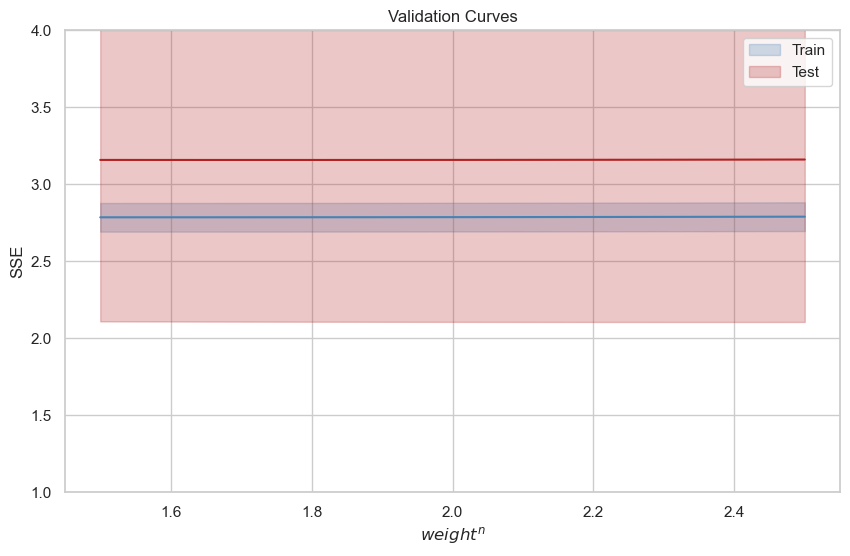

In [68]:
plot_validation_curves(results=result, metric="SSE", parameter=r"$weight^n$", values=values, zoom=True)

We can't see much here but it does look like it may hav a slight slope. Lets look very closely at these values to see.

In [69]:
for v, r in zip(values, result["test"]):
    print(v, result["test"][r])

1.5 (3.157968737603136, 0.5242921517653923)
1.6 (3.1577912527337286, 0.5245899716458201)
1.7 (3.157712254632277, 0.524891598956915)
1.8 (3.157731032634916, 0.5251961448515962)
1.9 (3.157846744572805, 0.5255027220111665)
2.0 (3.15805842069248, 0.5258104480167529)
2.1 (3.1583649679190864, 0.5261184486416286)
2.2 (3.1587651744405107, 0.5264258610346935)
2.3 (3.159257714582014, 0.52673183677971)
2.4 (3.159841153949695, 0.527035544792696)
2.5 (3.1605139547698577, 0.5273361741655629)


There is not much difference here, but we see 2.5 is the lowest value at 1.5 by a small .001 margin. We can leave our value as squared we will not see much improvement to change to 1.5.

### Validation Curve- model_year $^n$

Now we look at our $model year^n$ variable to see if we can find an n value that better minimizes the SSE. 

In [70]:
values = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
formulas = []
formula = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"
auto_temp = auto_df.copy()

for v in values:
    auto_temp[f'model_year_{str(v).replace(".", "_")}'] = auto_temp['model_year'] ** v

for v in values:
    f = f"mpg ~ model_year_{str(v).replace('.', '_')} + horsepower + weight + acceleration + model_year + origin + weight_squared + acceleration:horsepower"
    formulas.append(f)

def f(formula, data, v):
    return models.bootstrap_linear_regression(formula, data, style="linear")

In [71]:
result = validation_curves(f, formulas, auto_temp, values, lambda r: r["sigma"], repetitions=1)

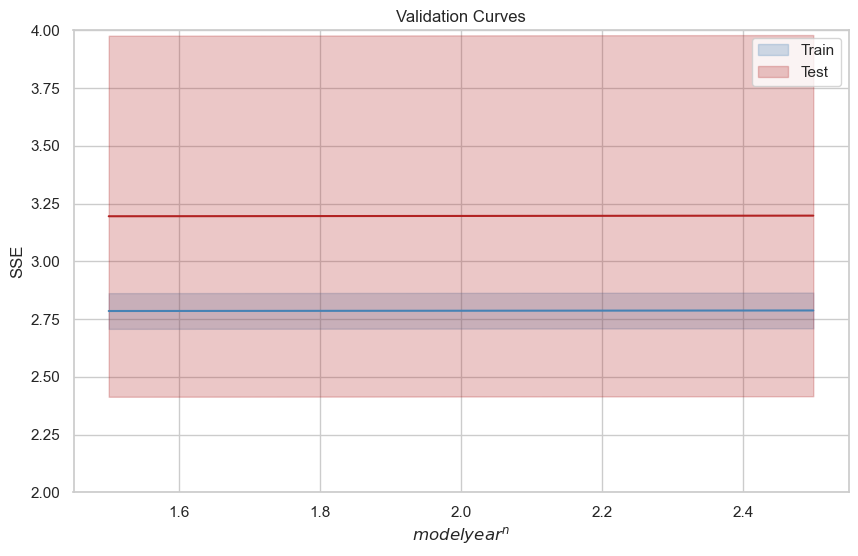

In [72]:
plot_validation_curves(results=result, metric="SSE", parameter=r"$model year^n$", values=values, zoom=True)

We see taht there is again not much of a change in the SSE for any difference in n values. Lets take a closer look:

In [73]:
for v, r in zip(values, result["test"]):
    print(v, result["test"][r])

1.5 (3.1947950584116507, 0.3907368837436768)
1.6 (3.1950614480046275, 0.3907528666945855)
1.7 (3.195328131205652, 0.39076922031101086)
1.8 (3.1955951022425277, 0.3907859436541043)
1.9 (3.195862354479949, 0.39080303515316134)
2.0 (3.1961298815700965, 0.39082049343022907)
2.1 (3.1963976771937435, 0.3908383171023997)
2.2 (3.1966657350071372, 0.39085650473572403)
2.3 (3.1969340486326874, 0.3908750549049388)
2.4 (3.1972026117228873, 0.3908939661829915)
2.5 (3.1974714179151733, 0.3909132371261796)


We see that all of the values are the same here for model year so there is no affect on depending on the different values.

## 1.4 - Describe the final model

* do this when you are completely, finally, and entirely done with building the model. This is a summary, in words, of the final model you would present to stakeholders before putting it into production).
* Look at *Fundamentals* and Labs 10 & 11 if you're not sure what goes here.

Now we need to go through and analyze our final model results. We had the final features for our model as:

In [100]:
final = "mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower"

Lets again look at our coefficients, and we will then talk through each variable and its meaning. 

In [101]:
final_model = models.bootstrap_linear_regression(final, auto_df, style="linear")
models.describe_bootstrap_lr(final_model)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,373.26,264.92,502.43
horsepower,$\beta_{1}$,0.05,0.01,0.09
weight,$\beta_{2}$,-0.02,-0.02,-0.01
acceleration,$\beta_{3}$,0.60,0.22,0.89
model_year,$\beta_{4}$,-9.28,-12.66,-6.40
origin,$\beta_{5}$,0.65,0.27,1.14
weight_squared,$\beta_{6}$,0.00,0.00,0.00
model_year_squared,$\beta_{7}$,0.07,0.05,0.09
acceleration:horsepower,$\beta_{8}$,-0.01,-0.01,-0.00


In [102]:
print(models.adjusted_r_squared(final_model))

0.8722478318833334


Interpreting the final model we get...

1. `horsepower` is positive: this is unexpected since we would think it would decrease MPG, but can make sense since better engines on smaller cars could have better fuel efficiency
2. `weight` is negative: this is expected since mpg typically decreases as weight increases. There is a -.02 relationship here
3. `acceleration` is positive: this is expected from what we saw in our initial model and is .60 MPG per 1 acceleration. This may seem counterintuitive, but newer faster engines also get better MPG
4. `model_year` is negative: this is unexpected since initially it was positive, but due to the affect of other coefficients MPG now decreases as model year increases. This is also affected by the positive model_year_squared term
5. `origin` is positive: this is expected as we saw in EDA origin 3 produces smaller vehicles with better MPG
6. `weight_squared` is 0: this term seems to not have an affect on the model alone but helps model the regression to the monotonic relationship of weight and MPG
7. `model_year_squared` is positive: this is expected and is due to the positive monotonic relationship between model year and MPG
8. `acceleration:horsepower` is negative: this is expected as acceleration is related to horsepower and weight and as the two incrase MPG decreases

This models accuracy (adjusted) averages 87.2% with a low of 85% and a high of 90% accuracy. We see that the model has somewhat counterintuitive variables such as the model year coefficient which shows a 9.28 MPG decrease per year newer for a car. This is not what we would initially expect, but makes sense when we consider the moderate and strong relationships between our variables. We compensated some by removing the displacement variable (which had the highest correlation with the other variables), but we can only do so much before we begin to lose accuracy in our model.

## 1.5 - Use the model

* and compare with the Null Model

## Predictions and compare with the Baseline Model

### Null Model Prediction

If we just look at the null model we have an estimated MPG of:

In [81]:
auto_df.mpg.mean()

23.514572864321607

with an error of:

In [82]:
auto_df.mpg.std()

7.815984312565782

The data is not totally symmetric for mpg so our best bet will be to use the 2.5% and 97.5% percentiles.

In [83]:
np.percentile(auto_df.mpg, [2.5, 97.5])

array([12.    , 39.1225])

Our predicted MPG based on the null model are 23.515 with an error bounds of 12 and 39.12

### Linear Regression Prediction

Lets see how our linear regression model does. We need a feature vector for a standard 1969 chevy malibu. I expect us to get a MPG of around 17-19 MPG. The features we need to input are:

In [103]:
print(final)

mpg ~ horsepower + weight + acceleration + model_year + origin + weight_squared + model_year_squared + acceleration:horsepower


In [143]:
horsepower = 132
weight = 3500
acceleration = 12
model_year = 69
origin = 3

weight_squared = weight**2
model_year_squared = model_year**2
acceleration_horsepower = acceleration * horsepower

chevy = [1, horsepower, weight, acceleration, model_year, origin, weight_squared, model_year_squared, acceleration_horsepower]

Again we should get a prediction of about 17 to 19 MPG

In [144]:
prediction = final_model["model"].predict([chevy])
prediction

array([[16.56825519]])

This is not exactly what we anticipated, but is within two MPG of what we predicted for the MPG. Lets see what our error bounds are:

In [145]:
prediction[0][0] - 1.96 * final_model["sigma"], prediction[0][0] + 1.96 * final_model["sigma"]

(11.106847826179887, 22.02966256330558)

We see a much narrower 95% error bounds than our null model with bounds of 11.10 MPG to 22.02 MPG (an 11.02 MPG window). This is over 20 MPG lower with the MPG error bounds for our null model from 12 to 39.12 MPG (a 27.12 MPG window). The linear regression model has cut our error bounds in half for our predicted MPG.



---

**CHECK LIST**

Before you submit this assignent, go back and review the directions to ensure that you have followed each instruction.



* Have you completed every section and answered every question asked?
* For every question, have you described your approach and explained your results?
* Have you checked for spelling and grammar errors?
* Are your code blocks free of any errors?
* Have you *SAVED* your notebook?
* Submit *THIS* notebook to the proper place in Blackboard.